# Snake
### Q learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qlearn import Qlearn
import torch

In [2]:
class Snake():
    
    movement = ([[1,0],[0,1],[-1,0],[0,-1]])
    
    def __init__(self,board,starting_size):
        # the board on which snake is playing
        self.grid = board.shape
        # position of head
        self.pos = None
        # direction facing
        self.d = 0
        # number of tail segments
        self.size = starting_size
        self.s_size = starting_size
        # position of tail segments
        self.segments = []
    
    def reset(self,pad=2):
        pad=0
        # pad starting position
        x = np.random.randint(pad,self.grid[0]-pad)
        y = np.random.randint(pad,self.grid[1]-pad)
        self.pos = (x,y)
        self.d = np.random.randint(4)
        self.size = self.s_size
        self.segments = []
        
    def move(self):
        # add head's position to segments
        self.segments.append(self.pos)
        # move head
        x,y = self.pos
        dx,dy = self.movement[self.d]
        self.pos = (x+dx,y+dy)
        # remove one segment if needed
        seg = None
        if (len(self.segments)>self.size):
            seg = self.segments.pop(0)
        # return new position and position that has been cleared
        return self.pos, seg
    
    def eat(self):
        self.size+=1

In [111]:
class Game():
    
    def __init__(self,grid,snake_size):
        self.board = np.ones((grid,grid,3))
        self.snake = Snake(self.board,snake_size)
        self.apple = None
        self.score = 0
        self.total = 0
        self.deaths = 0
    
    def reset(self):
        self.snake.reset()
        self.spawn_apple()
        self.draw()
    
    def draw(self):
        # white background
        self.board[:,:,:] = 1
        # black snake
        self.board[self.snake.pos[0],self.snake.pos[1],:] = 0
        for s in self.snake.segments:
            self.board[s[0],s[1],:] = 0
        # red apple
        self.board[self.apple[0],self.apple[1],1:] = 0
        
    def spawn_apple(self):
        # dummy x,y for while loop
        x,y = self.snake.pos
        # keep generating new apples until a free cell is rolled
        while ((x,y) in self.snake.segments+[self.snake.pos]):
            x = np.random.randint(self.board.shape[0])
            y = np.random.randint(self.board.shape[1])
        self.apple = np.array([x,y],dtype=int)
        self.new_apple = False
    
    def iterate(self):
        reward = 0
        # move snake
        new,old = self.snake.move()
        if (self.new_apple==True):
            self.spawn_apple()
        # check death condition
        grid = len(self.board)
        p = self.snake.pos
        a = self.apple
        if (p[0]<0 or p[0]>=grid or p[1]<0 or p[1]>=grid):
            # lose border
            self.lose()
            reward = -1
        elif (p in self.snake.segments):
            # lose self
            self.lose()
            reward = -1
        else:
            if (p == a).all():
                # eat apple
                self.eat() 
                reward = 1
            # update board (graphics)
            self.board[new[0],new[1],:] = 0
            if old is not None:
                self.board[old[0],old[1],:] = 1
        return reward
        
    def lose(self):
        self.reset()
        self.score=0
        self.deaths+=1
        
    def eat(self):
        self.snake.eat()
        self.score+=1
        self.total+=1
        old = self.apple
        #self.spawn_apple()
        # remove old apple (covered by snake)
        self.board[old[0],old[1],1:] = 0
        # paint new apple red
        #self.board[self.apple[0],self.apple[1],1:] = 0
        self.new_apple = True
    
    def get_state(self):
        grid = len(self.board)
        state = np.zeros(7)
        x,y = self.snake.pos
        'S,E,N,W'
        if ((x+1,y) in self.snake.segments or x+1>=grid):
            state[0] = 1
        if ((x-1,y) in self.snake.segments or x-1<0):
            state[2] = 1
        if ((x,y+1) in self.snake.segments or y+1>=grid):
            state[1] = 1
        if ((x,y-1) in self.snake.segments or y-1<0):
            state[3] = 1
        state[4] = np.sign(x-self.apple[0])
        state[5] = np.sign(y-self.apple[1])
        state[6] = len(self.snake.segments)
        return state

In [76]:
policy = {}
#0/1, 0/1, 0/1, 0/1, -1/0/1, -1/0/1
#(a-S, b-E, c-N, d-W)
# e: (row) 1 go north
# f: column 1 go west
#SENW

for a in range(2):
    for b in range(2):
        for c in range(2):
            for d in range(2):
                for e in range(-1,2):
                    for f in range(-1,2):
                        if (a==1):
                            S=0
                        else:
                            S=1
                        if (b==1):
                            E=0
                        else:
                            E=1
                        if (c==1):
                            N=0
                        else:
                            N=1
                        if (d==1):
                            W=0
                        else:
                            W=1
                        if (e==-1):
                            S*=10
                            N*=0.1
                        elif (e==0):
                            S*=0.1
                            N*=0.1
                        elif (e==1):
                            N*=10
                            S*=0.1
                        if (f==-1):
                            E*=10
                            W*=0.1
                        elif (f==0):
                            E*=0.1
                            W*=0.1
                        elif (f==1):
                            W*=10
                            E*=0.1
                        policy[(a,b,c,d,e,f)] = (S,E,N,W)

In [77]:
grid = 4
s_size = 1

In [78]:
g = Game(grid, s_size)
g.reset()
reward = 0

In [79]:
s = g.get_state()
a = policy[tuple(s)]
a = np.argmax(np.random.multinomial(1,np.array(a)/np.array(a).sum()))
g.snake.d = a
g.iterate() 
g.draw()
plt.imshow(g.board)
plt.show()
print(g.deaths,g.score,g.total)

KeyError: (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)

10
20
30
40
50
60
70
80
90
16789 0 12446
0.741318720590863


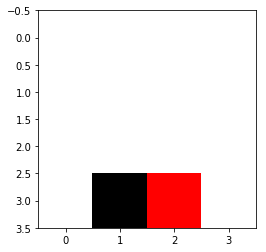

In [100]:
steps = 100000

brain = Qlearn([7,32,4],100000,0.9,1,100)

g = Game(grid, s_size)
g.reset()
reward = 0

progress = 0
for i in range(steps):
    if (progress<(int(100*(i/steps)))):
        progress = int(100*(i/steps))
        if (progress%10==0):
            print(progress)
    state = g.get_state()
    #if (reward==-1):
    #    d = brain.terminal_update(reward,state)
    #else:
    d = brain.update(reward,state)
    g.snake.d = d
    reward = g.iterate()   
# summarize game
print(g.deaths,g.score,g.total)
print(g.total/g.deaths)
plt.imshow(g.board)
plt.show()

In [103]:
# 11075 0 1062 - first
# ~11000 ~1500 - second
# 21055 4550 - third
# 16789 12446 - 4th (14/04) best ever (reward was 10000)

In [104]:
bu = brain.memory.copy()

10
20
30
40
50
60
70
80
90
14563 0 18623
1.278788711117215


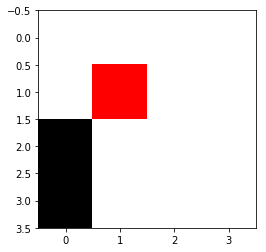

In [108]:
steps = 100000

# do not reset brain
brain.memory.clear()
#brain = Qlearn([7,32,4],100000,0.9,1,100)

g = Game(grid, s_size)
g.reset()
reward = 0

progress = 0
for i in range(steps):
    if (progress<(int(100*(i/steps)))):
        progress = int(100*(i/steps))
        if (progress%10==0):
            print(progress)
    state = g.get_state()
    #if (reward==-1):
    #    d = brain.terminal_update(reward,state)
    #else:
    d = brain.update(reward,state)
    g.snake.d = d
    reward = g.iterate()   
# summarize game
print(g.deaths,g.score,g.total)
print(g.total/g.deaths)
plt.imshow(g.board)
plt.show()

10
20
30
40
50
60
70
80
90
15139 1 18263
1.2063544487746878


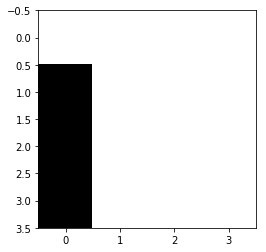

In [109]:
steps = 100000

# do not reset brain
brain.memory.clear()
#brain = Qlearn([7,32,4],100000,0.9,1,100)

g = Game(grid, s_size)
g.reset()
reward = 0

progress = 0
for i in range(steps):
    if (progress<(int(100*(i/steps)))):
        progress = int(100*(i/steps))
        if (progress%10==0):
            print(progress)
    state = g.get_state()
    #if (reward==-1):
    #    d = brain.terminal_update(reward,state)
    #else:
    d = brain.update(reward,state)
    g.snake.d = d
    reward = g.iterate()   
# summarize game
print(g.deaths,g.score,g.total)
print(g.total/g.deaths)
plt.imshow(g.board)
plt.show()

In [ ]:
steps = 1000000

brain = Qlearn([7,32,4],1000,0.9,1,1000)

g = Game(grid, s_size)
g.reset()
reward = 0

progress = 0
for i in range(steps):
    if (progress<(int(100*(i/steps)))):
        progress = int(100*(i/steps))
        if (progress%10==0):
            print(progress)
    state = g.get_state()
    #if (reward==-1):
    #    d = brain.terminal_update(reward,state)
    #else:
    d = brain.update(reward,state)
    g.snake.d = d
    reward = g.iterate()   
# summarize game
print(g.deaths,g.score,g.total)
print(g.total/g.deaths)
plt.imshow(g.board)
plt.show()

10
20
30
40
50
60
70
80


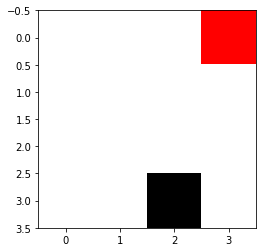

[ 1.  0.  0.  0.  1. -1.  0.] 1


In [87]:
state = g.get_state()
if (reward==-1):
    d = brain.terminal_update(reward,state)
else:
    d = brain.update(reward,state)
g.snake.d = d
reward = g.iterate() 
g.draw()
plt.imshow(g.board)
plt.show()
g.new_apple
print(g.get_state(),d)

In [95]:
s = [[0,0,0,0,1,1,0],[1,0,0,0,1,1,0],[0,1,0,0,1,1,0],[0,0,1,0,1,1,0],[0,0,0,1,1,1,0],[1,1,0,0,1,1,0],[1,0,1,0,1,1,0],[1,0,0,1,1,1,0]]
s = torch.Tensor(s)
with torch.no_grad():
    s = torch.autograd.Variable(s)
brain.network(s)

tensor([[ 0.2695,  0.1169,  0.2599,  0.3756],
        [-0.3837,  0.1048,  0.2039,  0.3723],
        [ 0.1914, -0.3737,  0.1377,  0.4517],
        [ 0.0760,  0.0630, -0.0216,  0.3478],
        [ 0.1650, -0.1132,  0.2377,  0.1797],
        [-0.5365, -0.5106,  0.1212,  0.3998],
        [-0.5728,  0.0606, -0.0811,  0.3422],
        [-0.4911, -0.0627,  0.2040,  0.0415]], grad_fn=<AddmmBackward>)

In [40]:
#SENW
# -3 S, 1 W

In [96]:
s = [[0,0,0,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,-1,0],[0,0,0,0,-1,0,0]]
s = torch.Tensor(s)
with torch.no_grad():
    s = torch.autograd.Variable(s)
brain.network(s)

tensor([[ 0.7531,  0.5864,  0.2030, -0.0513],
        [ 0.1939,  0.2082,  0.2611,  0.0668],
        [ 0.3438,  0.2778,  0.0866,  0.1290],
        [ 0.3121,  0.0823, -0.1314,  0.0903]], grad_fn=<AddmmBackward>)

In [98]:
brain.memory[:100]

[(tensor([[1., 0., 0., 1., 1., 0., 0.]]),
  tensor([[1., 0., 0., 1., 1., 0., 1.]]),
  tensor([0.]),
  tensor([2])),
 (tensor([[1., 0., 0., 1., 1., 0., 1.]]),
  tensor([[ 0.,  0.,  0.,  1., -1., -1.,  0.]]),
  tensor([0.]),
  tensor([3])),
 (tensor([[ 0.,  0.,  0.,  1., -1., -1.,  0.]]),
  tensor([[ 0.,  0.,  1.,  0., -1.,  1.,  0.]]),
  tensor([-1.]),
  tensor([3])),
 (tensor([[ 0.,  0.,  1.,  0., -1.,  1.,  0.]]),
  tensor([[ 0.,  1.,  1.,  1., -1.,  1.,  1.]]),
  tensor([-1.]),
  tensor([1])),
 (tensor([[ 0.,  1.,  1.,  1., -1.,  1.,  1.]]),
  tensor([[ 0.,  0.,  1.,  0., -1.,  1.,  0.]]),
  tensor([0.]),
  tensor([1])),
 (tensor([[ 0.,  0.,  1.,  0., -1.,  1.,  0.]]),
  tensor([[ 0.,  1.,  1.,  0., -1.,  0.,  1.]]),
  tensor([-1.]),
  tensor([3])),
 (tensor([[ 0.,  1.,  1.,  0., -1.,  0.,  1.]]),
  tensor([[ 0.,  1.,  1.,  1., -1., -1.,  1.]]),
  tensor([0.]),
  tensor([3])),
 (tensor([[ 0.,  1.,  1.,  1., -1., -1.,  1.]]),
  tensor([[ 0.,  0.,  1.,  0., -1., -1.,  0.]]),
  tensor([

In [42]:
[i for i in brain.memory if i[2]>0.1]

[(tensor([[1., 0., 0., 0., 0., 0.]]),
  tensor([[ 0.,  0.,  1.,  0., -1., -1.]]),
  tensor([10000.]),
  tensor([0])),
 (tensor([[0., 1., 0., 0., 0., 0.]]),
  tensor([[ 0.,  0.,  1.,  0., -1., -1.]]),
  tensor([10000.]),
  tensor([0])),
 (tensor([[0., 1., 0., 1., 0., 0.]]),
  tensor([[ 0.,  0.,  0.,  1.,  1., -1.]]),
  tensor([10000.]),
  tensor([1])),
 (tensor([[0., 0., 1., 0., 0., 0.]]),
  tensor([[0., 1., 0., 1., 1., 1.]]),
  tensor([10000.]),
  tensor([1])),
 (tensor([[1., 0., 0., 0., 0., 0.]]),
  tensor([[ 0.,  1.,  0.,  1.,  0., -1.]]),
  tensor([10000.]),
  tensor([3])),
 (tensor([[1., 1., 1., 0., 0., 0.]]),
  tensor([[ 1.,  1.,  0.,  0.,  1., -1.]]),
  tensor([10000.]),
  tensor([3])),
 (tensor([[1., 0., 0., 1., 0., 0.]]),
  tensor([[ 0.,  1.,  1.,  0., -1.,  1.]]),
  tensor([10000.]),
  tensor([0])),
 (tensor([[1., 1., 1., 0., 0., 0.]]),
  tensor([[ 0.,  0.,  0.,  0., -1., -1.]]),
  tensor([10000.]),
  tensor([2])),
 (tensor([[1., 0., 0., 0., 0., 0.]]),
  tensor([[ 0.,  0.,  0.

In [ ]:
torch.save(brain.network.state_dict(), 'dqn_080419_b')

#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()